## Using Random Forest Models To Predict Sleep Patterns Based On Average Daily Action Counts

In [ ]:
#authored by Tom Odem on 19 November 2023

### Imports

In [1]:
import modules
import numpy as np
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

### Retrieving and categorizing data

In [7]:
X = modules.get_and_avg_data() #get data averaged over 7 day increments
Y = X['avg_sleep'].copy() #extract labels from set
X = X.drop(labels=['depression_class','avg_sleep'], axis = 1) #drop the depression class because we will be using the depression scores instead and drop avg_sleep because those are our labels
X = X.apply(modules.categorize_column, axis=0) #categorize the columns into 3 categories 0 = less than average, 1 = average, 3 = more than average
Y = modules.categorize_column(Y) #categorize labels into 3 categories just like above

no user_tags: 520
no user_tags: 532
no user_tags: 503
no user_tags: 503
no user_tags: 523
no user_tags: 544
no user_tags: 529
no user_tags: 661
no user_tags: 658
no user_tags: 664
no user_tags: 634
no user_tags: 507
no user_tags: 547
no user_tags: 501
no user_tags: 668
no user_tags: 662


For averaged user data, our data is obtained via three different file models: user_information.csv, which lists every user who participated in the study, user_tag files, which are individual files for each user that documents every action that was recorded throughout the study, and user_data files, which documents exact times that activity tags are triggered and also records the user's step amount at each tag trigger. The function get_and_avg_data() first opens the user_data file and user_tag data file for a user and computes the amount they slept, number of times they ate, number of times they drank, number of times they completed a self care act, and the amount of steps they took for everyday the user had data recorded. After getting the daily counts, the function computes averages over avg_of_n_days days, which is a user defined function parameter. This is done by selecting the first avg_of_n_days day from the daily data and computing the average of every feature. These averages, along with the user's depression information, is then appended as an individual new user to an averages dataframe. We then select the next avg_of_n_days days and compute averages , then the next, and so on until we reach the end of the recorded days. This is done for each user in which we have files for, to get a final number of 37-users-with-files * (number-of-days-recorded-for-user / avg_of_n_days) data points to train and classify with.
One might think, "why not average over all days for each user?" While that would be optimal, we only have 37 users who actually had retrievable data, and trying to train these big fancy models with only 37 data points would not be very productive. So, we split the data up into countless new users based on average over days. In essence, all of the new "pseudo-users" created from a single user are treated as individual users who just happen to have the same depression information. Since we are trying to find patterns in depression based on daily activity within a population, we can assume that this small population can also represent a wider range of population, which is simulated via these averages.

Instead of trying to predict an exact continuous number of hours of sleep, we want our random forest to predict how a user will sleep compared to the average amount of sleep in the population. Todo this we use the same function as we did to put our data in categories for the Naive Bayes model: Compute the mean and standard deviation of sleep among the entire population and then put the sleep data into categories based on if the sleep amount is within one standard deviation of the mean. Users who have more than average sleep are designated as 2, an average amount is 1, and less than average is 0. With our labels categorized, we can now predict sleep amount based on three classes. Unlike the Naive Bayes data preprocessing, we keep the data points continuous. This is because the decision trees within a random forest are very good at finding the split point in continuous data.

### Finding the best parameters for our random forest using 10-fold cross validation

In [20]:
#define the parameters we will be testing in cross validation
num_trees = [5,10,20,30,40,50,60,70,80,90,100]
criterions = ['gini', 'entropy', 'log_loss']
min_samples_splits = [2,4,8,16]

Random forests have a large amount of paramaters that can be tweaked in order to get various results. To test different builds of random forests, we completed a 10-fold corss validation for many different sets of parameters. The only "overbearing" tree parameter we test is min_samples_split, which controls the least amount of samples we need to split the tree at a leaf. This is because min_samples_split affects all other parameters in the created decision trees and could possibly lead to overfitting if left too low. Additionally, all other "overbearing" parameters can limit expansion of a tree where the expansion would most likely be useful. Max depth, for example, would halt any more splits from happening, even when the splits would help us discriminate between samples more accurately. Here we define an "overbearing" parameter as any parameter that halts the natural process of making new splits in decisions trees. In addition to min_samples_split, we tested different split criterion in order to find which one will maximize performance and also tested various sizes of random forests to control the number of trees, in hopes of reducing overfitting that can occur in larger forests. The values tested are as follows: min_samples_split = {2,4,8,16}, criterions = {'gini', 'entropy', 'log_loss'}, and num_trees = {5,10,20,30,40,50,60,70,80,90,100}.

In [26]:
#finding the best parameters
               #num_tree, criterion, min_sample_split, accuracy
best_results = [0,        None,      0,                0.0]
for num_tree in num_trees:
    for criterion in criterions:
        for min_sample_split in min_samples_splits:
            k_fold = KFold(n_splits=10, shuffle=True, random_state=57) #define how many k-folds we want, shuffle the data when choosing
            clf = RandomForestClassifier(n_estimators=num_tree, criterion=criterion,min_samples_split=min_sample_split, random_state=56) #define the random forest we want to be testing this iteration
            accuracy_scores = cross_val_score(clf, X, Y, cv=k_fold, n_jobs=1) #evaluate the above defined model using 10-fold cross validation
            avg_accuracy = np.mean(accuracy_scores) #find the mean accuracy
            if(avg_accuracy > best_results[3]): #save the current parameters if the accuracy is better than the current best
                best_results = [num_tree, criterion, min_sample_split, avg_accuracy]
            

In [33]:
#get the best parameters
num_tree = best_results[0]
criterion = best_results[1]
min_sample_split = best_results[2]
print(f'The best parameters found via 10-fold cross validation: \nnum_tree-{num_tree} \ncriterion-{criterion} \nmin_sample_split-{min_sample_split}')

The best parameters found via 10-fold cross validation: 
num_tree-70 
criterion-entropy 
min_sample_split-16


After testing 132 different models using 10-fold cross validation, we found that the best model had to have a minimum of 16 samples to split a leaf, used entropy as its split criteria, and had a maximum of 70 trees.

### Train and evaluate our best found model

In [28]:
#split up our data into trains and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 68)

In [32]:
#evaluate our model using the best found parameters
clf = RandomForestClassifier(n_estimators=num_tree, criterion=criterion,min_samples_split=min_sample_split, random_state=56)
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
best_accuracy = accuracy_score(Y_pred, Y_test)

#now evaluate a model where all parameters were default
clf = RandomForestClassifier(random_state=56)
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
null_accuracy = accuracy_score(Y_pred, Y_test)

#print the accuracies for comparision
print(f'Accuracy of Random Forest model with best found parameters: {best_accuracy}\nAccuracy of Random Forest model with default parameters: {null_accuracy}')

Accuracy of Random Forest model with best found parameters: 0.7706422018348624
Accuracy of Random Forest model with default parameters: 0.7522935779816514


Using these values, we trained a random forest model on a training set and evaluated it on a test set using a 90-10 split. The accuracy of our model came out to 77.06%. This means that given a user's average daily habits, we can predict if they get more than average, less than average, or an average amount of sleep with 77.06% accuracy. We also tested what the accuracy would have been if we had not found a best set of paramters by training a model using the default values of the random forest classifier. This gave an accuracy of 75.23%, a 1.83 reduction from the model using optimal parameters.

<BarContainer object of 2 artists>

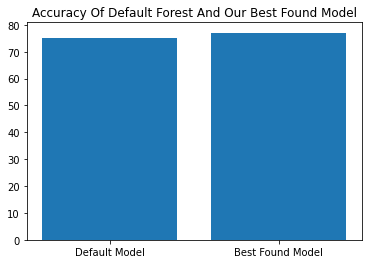

In [2]:
models = ['Default Model', 'Best Found Model']
accuracies = [75.23, 77.06]
plt.title('Accuracy Of Default Forest And Our Best Found Model')
plt.bar(models,accuracies)